# Lecture 37 - Best Learning Practices & Introduction to Deep Learning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# Best Practices for Training ANNs

## 1. Defining Network Architecture

Suppose you have a set of data $\{x_i\}_{i=1}^N \in \mathbb{R}^D$. 

* What size network should you choose? How many layers? How many units per layer?

**Input Layer**

* Regardless of whether you are utilizing processing the **input space** or **feature space** of a given data set, the number of neurons in the input layer is the same as the dimensionality of the space.

**Output Layer**

* Suppose you are trying to do classification, then your output layer will represent the class labels.
* You can have different types of output encoding which directly impact performance.

**Output Layer Encoding (also called Feature Engineering):**
* Common encoding methods for classification:
    1. Integer encoding label for each class
    2. One-hot encoding (binary vectors with one indicator for each class)
    3. Binary (or other base) encoding
    
**Hidden Layer**
* We don't really know how many neurons to add in the hidden layer or how many hidden layers to use.
* **Rule of Thumb**: the amount of training data you need for a *well* performing model is 10x the number of parameters in the model.
    * Data will directly impact model choice...
    
**Example:** A network is said to have architecture 10-100-50-5 if its input layer has 10 units, 1st hidden layer 100 units, 2nd hidden layer 50 units and output layer 5 units.

In [ ]:
from sklearn import datasets
digits = datasets.load_digits()

X = digits.data
y = digits.target

print(X.shape, y.shape, digits.target_names)

In [ ]:
fig = plt.figure(figsize=(7,4))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    ax.imshow(X[np.where(y==i)[0][1],:].reshape((8,8)), cmap='binary')
    plt.title('Label '+str(i))

In [ ]:
# Data Normalization

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X=scaler.fit_transform(X)

In [ ]:
# Splitting into Training-Test Sets (80/20)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

In [ ]:
from sklearn.neural_network import MLPClassifier

?MLPClassifier

## 2. Learning Rate

Backpropagation provides an approximation to the trajectory in the weight space computed by the method of **gradient descent**.

* The gradient descent is a 1st-order optimization algorithm (uses 1st derivative)

* Other methods can also be used, for example, Newton's method, a 2nd-order optimization algorithm (uses 2nd derivative)

**Delta Rule**

\begin{align}
w^{(t+1)} &= w^{(t)} + \Delta w^{(t)}\\
\Delta w^{(t)} &= - \eta \nabla J(w^{(t)})\\
\nabla J(w^{(t)}) &= w^{(t+1)} - w^{(t)}
\end{align}

Stable values for the learning rate $\eta$ are $0 < \eta < 1$.

* When $\eta >0$ but small (e.g. $0 <\eta <0.001$), the cost function decreases, the weights are updated very slowly and the learning trajectory is smooth.

* When $\eta > 0$ but too large (e.g. $\eta>1000$), may result in large changes in the weights and cause the cost function to become unstable (oscillatory).

In [ ]:
rng_seed = 10
hdn_lyr_sz = (25, 15)
alpha = 0.001
beta = 0
batch_size = 25
solver = 'sgd'

plt.figure(figsize=(10,5))
acc = []
for eta in [0.001, 0.01, 0.1, 0.3]:
    mlp = MLPClassifier(activation='relu',hidden_layer_sizes=hdn_lyr_sz, 
                        solver=solver,alpha=alpha, batch_size=batch_size,
                        learning_rate_init=eta, random_state=rng_seed, 
                        momentum=beta, nesterovs_momentum=False)

    mlp.fit(X_train, y_train)
    est = mlp.predict(X_test)
    acc.append(np.sum(est == y_test) / len(y_test) * 100)
    plt.plot(mlp.loss_curve_, label='$\eta$='+str(eta))

plt.xlabel('Epochs', size=15)
plt.ylabel('Error', size=15)
plt.title('Learning Curves', size=15)
plt.legend();

## 3. Optimization Techniques with Gradient Descent

1. **Accelerated Gradient Descent strategies**: (1) add a momentum term, (2) use Nesterov's formula

2. **Adaptive Learning Rate**: (1) AdaGrad, (2) Adam

3. **Gradient Descent for ML**: (1) Stochastic Gradient Descent, (2) Batch/Mini-batch Gradient Descent

1. **Accelerated Gradient Descent**

We can include a **momentum term**: it tries to increase rate of learning while avoiding instability. 

The **Generalized Delta Rule - Delta Rule with momentum** is:

$$\Delta w_{ji}^{(t)} = \alpha \Delta w_{ji}^{(t-1)} - \eta \delta_j^{(t)} y_i^{(t)}$$

where $\alpha$ is usually set to 0.9 or a similar value, and $(t)$ stands for iteration.

Observations:
* $\Delta w_{ji}(n)$ is a the sum of exponentially weighted time series. For it to converge, $0 \leq |\alpha| < 1$
* If $\alpha = 0$, then we are operating without a momentum term

* Inclusion of momentum accelerates descent in steady down-hill directions
* Inclusion of momentum has a stabilizing effect in directions that oscillate in sign
* Momentum may prevent termination/convergence in a shallow/local minimum

* The learning rate *can* be connection dependent, $\eta_{ji}$, we can even set it to zero for some connections
* Yurii Nesterov noticed that as we reach the minima i.e the lowest point on the curve, the momentum is pretty high and it does not know to slow down at that point due to the high momentum which could cause it to miss the minima entirely and continue moving up. He introduced the now called **Nesterov accelerated gradient (NAG)**.

2. **Nesterov Accelerated Gradient (NAG)**

$$w_{ij}^{(t)} = y^{(t)} - \eta \nabla J(y^{(t)})$$

$$y^{(t)} = w_{ij}^{(t)} + \mu (w_{ij}^{(t)} - w_{ij}^{(t-1)})$$

* **Gradient Descent with momentum**: (1) computes the gradient at current location, and then (2) to that gradient, adds a momentum step in the direction of the previous gradient.

* **NAG**: (1) adds a momentum term in the direction of the previous gradient, and then (2) computes the gradient at that location.

3. **Adaptive Learning Rate**

In addition to being able to speed up Gradient Descent, we can also **update the learning rate** to perform larger or smaller updates depending on their importance.

$$\Delta w_{ij}^{(t)} = - \eta^{(t)} \nabla J(w_{ij}^{(t)})$$

* **AdaGrad ([Adaptive Gradient algorithm, 2011](https://jmlr.org/papers/volume12/duchi11a/duchi11a.pdf))**: It simply allows the learning rate to decrease based on the parameters of the network. So it makes big updates for infrequent parameters, and small updates for frequent parameters. For this reason, it is well-suited for dealing with sparse data. Its main weakness is that its learning rate is always decreasing and decaying.

* **RMSProp ([Root Mean Squared Progagation algorithm, 2012](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)):** RMSProp is also a method in which the learning rate is adapted for each of the parameters in the network. The idea is to divide the learning rate for a parameter by a running average of the magnitudes of recent gradients for that weight.

* **Adam ([Adaptive Moment Estimation, 2015](https://arxiv.org/abs/1412.6980)):** Adam combines RMSProp and momentum learning. It is by far the most common method used today. Adam also computes adaptive learning rates for each parameter of the network. In this optimization algorithm, running averages of both the gradients and the second moments of the gradients are used.

In [ ]:
hdn_lyr_sz = (25, 15)
alpha = 0.001
eta = 0.01
batch_size = 25
beta = (0, .9, .9, 0)
n_beta = (False, False, True, False)
solver = ('sgd', 'sgd', 'sgd', 'adam')
labels = ('SGD no momentum', 'SGD momentum', 'SGD Nesterov momentum', 'Adam')

plt.figure(figsize=(10,5))
for i in range(4):
    mlp = MLPClassifier(hidden_layer_sizes=hdn_lyr_sz, solver=solver[i],
                      alpha=alpha, batch_size=batch_size,
                      learning_rate_init=eta, random_state=rng_seed, 
                      momentum=beta[i], nesterovs_momentum=n_beta[i])

    mlp.fit(X_train, y_train)
    plt.plot(mlp.loss_curve_, label=labels[i])

plt.xlabel('Epochs', size=15)
plt.ylabel('Error', size=15)
plt.title('Learning Curves', size=15)
plt.legend();

## 4. Online/Stochastic vs Batch Learning

The number of samples used to perform a single training iteration (forward pass + backward pass) will impact the results.

* **Online Learning** (or stochastic/sequential learning): uses one sample to update the parameters of the network.
* **Batch Learning:** uses the entire training set to update the parameters of the network.

**Online Learning**

* Online learning performs local updates based on a single data sample

* One **iteration** consists of a forward pass and a backward pass

* One **epoch** consists of a pass through all training samples

* Suppose we have $N$ training samples, then one epoch has $N$ parameter updates.

* It is good practice to randomly reorder the data points between each epoch. Yes! *Why?*

* Online mode of training requires less local storage for each synaptic connection

* Online mode of training makes the search in the weight space *stochastic* in nature

**Batch Learning**

* Batch learning performs *global* updates based on the entire training set

* One epoch in Batch learning, only has 1 iteration

* The errors in backward pass are the averaged error over all training samples

* Batch mode can ensure convergence to at least a local minimum

* Batch mode is easier to parallelize

* If a data set is has correlated features, online learning is more able to take advantage of this - unlike batch learning

**Mini-Batch Learning**

* We can consider mini-batch sets and perform updates based on each mini-batch.

* Similarly to online learning, it is common practice to create new random samples for each mini-batch set for each epoch. *Why?*

* Mini-batches need to be balanced for class representation

* Common sizes are 32, 64 and 128

In [ ]:
rng_seed = 10
hdn_lyr_sz = (25, 15)
alpha = 0.001
eta = 0.01
beta = 0
solver = 'sgd'

plt.figure(figsize=(10,5))
acc = []
for batch_size in range(1,100,32):
    mlp = MLPClassifier(hidden_layer_sizes=hdn_lyr_sz, solver=solver,
                      alpha=alpha, batch_size=batch_size,
                      learning_rate_init=eta, random_state=rng_seed, 
                      momentum=beta, nesterovs_momentum=False)

    mlp.fit(X_train, y_train)
    est = mlp.predict(X_test)
    acc.append(np.sum(est == y_test) / len(y_test) * 100)
    plt.plot(mlp.loss_curve_, label='bSize=%d, Acc.=%2.2f%%' % (batch_size, acc[-1]))

plt.xlabel('Epochs', size=15)
plt.ylabel('Error', size=15)
plt.title('Learning Curves', size=15)
plt.legend();

## 5. Stopping Criteria

Backpropagation cannot be shown to converge. We want it to stop at the global minimum. A necessary condition for this is $J(w^*)=0$.

**Criterion 1**: The Backpropagation algorithm is considered to have converged when the Euclidean norm of the gradient vector reaches a sufficiently small threshold
* learning may take a long time
* must compute the norm of the gradient vector

**Criterio 2**: The Backpropagation algorithm is considered to have converged when the absolute rate of change in the average squared error per epoch is sufficiently small.
* may result in premature termination of learning
* can test after each epoch for generalization ability, when it peaks, then stop

## 6. Overfitting, Generalization & Cross-Validation

Generalization is mostly influenced by three factors:
1. Size of training set (may or may not have control)
2. Architecture of the network (we control)
3. Physical complexity of problem (no control)

* The goal is to reduce generalization error (error when given inputs from the test set)

* When complexity is small compared to training size, performance is generally insensitive to training data size

* As target function gets more complex, relative to training size, the size of the training set has more effect

* The Rule of thumb: 80% training, 20% testing

* We should also use cross-validation

## 7. Minimizing Information Content

* Cross-Entropy cost function
* Provide training samples that provide the largest information content
* Use example with largest training error
* Use example radically different than the ones before

* Emphasizing scheme, present more difficult patterns to the network, difficulty is determined by error
* Problems with emphasizing scheme:
    * Distribution of samples in an epoch is distorted
    * Outliers or mislabeled samples can cause major problems

## 8. Activation Functions

MLPs may learn better with activation functions that are antisymmetric $\phi(-v) = -\phi(v)$ (e.g. hyperbolic tangent function) rather than non-symmetric (e.g. sigmoid function)
* If the activation function is non-symmetric, the output of each neuron is restricted to the interval $[0,1]$. Such a choice introduces a source of systematic bias for those neurons located beyond the first layer of the network.

* With an antisymmetric activation function, the output of each neuron is permitted to assume both positive and negative values in the interval $[-1,1]$, in which case it is likely for its mean to be zero.
* If the network connectivity is large, backpropagation learning with anti-symmetric activation functions can yield faster convergence than a similar process with non-symmetric, for which there is also empirical evidence.

In [ ]:
rng_seed = 10
hdn_lyr_sz = (25, 15)
alpha = 0.001
eta = 0.01
beta = 0
batch_size = 5
solver = 'sgd'

plt.figure(figsize=(10,5))
acc = []
for act_fcs in ['identity', 'logistic','tanh','relu']:
    mlp = MLPClassifier(activation=act_fcs,hidden_layer_sizes=hdn_lyr_sz, 
                        solver=solver,alpha=alpha, batch_size=batch_size,
                        learning_rate_init=eta, random_state=rng_seed, 
                        momentum=beta, nesterovs_momentum=False)

    mlp.fit(X_train, y_train)
    est = mlp.predict(X_test)
    acc.append(np.sum(est == y_test) / len(y_test) * 100)
    plt.plot(mlp.loss_curve_, label=act_fcs)

plt.xlabel('Epochs', size=15)
plt.ylabel('Error', size=15)
plt.title('Learning Curves', size=15)
plt.legend();

## 9. Data Scaling

Data scaling is an important step of a ML system and an MLP is no different.

* For the learning time to be minimized, the use of *non-zero mean inputs should be avoided*
* It is good if the input variables are uncorrelated
* It is good if variances are approximately equal (standardization)

In [ ]:
net = MLPClassifier(activation='relu',hidden_layer_sizes=(25,15), solver='adam',
                  alpha=0.001, batch_size=5,learning_rate_init=0.01, random_state=rng_seed, 
                  momentum=0.9, nesterovs_momentum=True)

net.fit(X_train, y_train)

In [ ]:
print("weights between input and hidden layer:")
print(net.coefs_[0].shape)
print("biases between input and hidden layer:")
print(net.intercepts_[0].shape)
print("\nweights between hidden and output layer:")
print(net.coefs_[1].shape) 
print("biases between hidden and output layer:")
print(net.intercepts_[1].shape)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print('TRAINING PERFORMANCE')
y_predtrain = net.predict(X_train)
accuracy_train = np.round(accuracy_score(y_train, y_predtrain),2)
print('Accuracy in the Train set= ', accuracy_train*100, '%')
print(classification_report(y_train, y_predtrain))
print('----------------------------------------------------------')

print('TEST PERFORMANCE')
y_predtest = net.predict(X_test)
accuracy_test = np.round(accuracy_score(y_test, y_predtest),2)
print('Accuracy in the Test set= ', accuracy_test*100, '%')
print(classification_report(y_test, y_predtest))

print('Confusion matrix in Test:')
print(confusion_matrix(y_test, y_predtest))

## 10. Initialization

The initialization of the weights of neural networks is a whole field of study as the careful initialization of the network can speed up the learning process.

Most common: small Normal random values.

Other methods include: zeros, ones, constant, uniformly random, truncated Normal random, orthogonal, identity, LeCun uniform, LeCun normal,  He uniform, He normal, Xavier uniform, Xavier normal.

## 11. Network Pruning Techniques

* **Network Growing**: Start with a small MLP and add to it when unable to meet design specifications

* **Network Pruning**: Start with a large MLP and prune it by eliminating weights (driving them to zero)

* **Complexity Regularization**: Need an appropriate trade-off between reliability of training data and goodness of the model/NN architecture

* We can find trade-off my minimizing the total risk: 

$$R(w) = J_e(w)+ \lambda J_c(w)$$ 

where $J_e$ is the performance/error measure, $J_c$ is the complexity penalty, and $\lambda$ is a regularization parameter that represents the relative importance of the complexity penalty with respect to the performance measure term.
* $\lambda = 0$: Training based only on training samples
* $\lambda \rightarrow \infty$: Training samples are unreliable, minimize complexity

1. **Weight Decay:** $J_c(w) = \Vert w\Vert_2^2 = \sum_i w_i^2$

2. **Weight Sparsity:** $J_c(w) = |w| = \sum_i |w_i|$

3. **Weight Elimination:**
$$ J_c(w) = \sum_i \frac{\left(\frac{w_i}{w_0}\right)^2}{1+\left(\frac{w_i}{w_0}\right)^2}$$

In [ ]:
N = 1000
w = np.linspace(-4,4,N)
w0 = 1
Jc1 = w**2/np.max(w**2)
Jc2 = np.abs(w)/np.max(np.abs(w))
Jc3 = (w/w0)**2/ (1 + (w/w0)**2)

plt.plot(w, Jc1, label = 'Weight Decay'); 
plt.plot(w, Jc2, label = 'Weight Sparsity');
plt.plot(w, Jc3, label = 'Weight Elimination'); 
plt.legend(loc='lower left')
plt.title("Network Pruning"); 
plt.xlabel("Weights");

### Emsemble Learning: Boosting

Boosting is an ensemble learning method.

If we take a collection of very poor (weak in the jargon) learners, each performing only just better than chance, then by putting them together it is possible to make an ensemble learner that can perform arbitrarily well. So we just need lots of low-quality learners, and a way to put them together usefully, and we can make a learner that will do very well.

The principal algorithm of boosting is named **AdaBoost** (Adaptive Boosting). Essentially, it give weights to each data point according to how difficult previous learners have found to get it correct. These weights are given to the classifier as part of the input when it is trained. The predictions from all learners are then combined through a weighted majority vote (or sum) to produce the final prediction.

Example: random forests

### Emsemble Learning: Bagging

Bagging (bootstrap aggregating) is an emsemble learning method. Bagging is a technique for reducing generalization error by combining several models. The idea is to train several different models separately, then have all the models vote on the output for test examples. This is an example of a general strategy in machine learning called model averaging. The reason that model averaging works is that different models will usually not make all the same errors on the test set.

Bagging methods work best with strong and complex models, in contrast with boosting methods which usually work best with weak models.

## 12. Determining Whether to Gather More Data

After the ﬁrst end-to-end system is established, it is time to measure the performance of the algorithm and determine how to improve it. It is often much better to gather more data than to improve the learning algorithm (or first model of choice).

How does one decide whether to gather more data?

1. Determine whether the performance on the training set is acceptable. If performance on the training set is poor, the learning algorithm is not using the training data that is already available, so there is no reason to gather more data. 
    * Instead, try adding complexity to the model by adding more layers or adding more hidden units to each layer. 
    * Also, try improving the optimization algorithm, for example by tuning the learning rate. 
    * If more complex models and carefully tuned optimization algorithms do not work well, then the problem might be the *quality* of the training data. The data may be too noisy or may not include the right inputs needed to predict the desired outputs. This suggests starting over, collecting cleaner data, or collectinga richer set of features.

2. If the performance on the training set is acceptable, then measure the performance on a test set. If the performance on the test set is also acceptable, then there is nothing left to be done. If test set performance is much worse than training set performance, then gathering more data is one of the most effective solutions. In some applications, gathering more data is simply infeasible or impossible. 
    * A simple alternative to gathering more data is to reduce the size of the model or improve regularization, by adjusting hyperparameters such as weight decay coeﬃcients,or by adding regularization strategies such as dropout. 
    * If you ﬁnd that the gap between train and test performance is still unacceptable even after tuning the regularization hyperparameters, then gathering more data is advisable.
    
3. When deciding whether to gather more data, it is also necessary to decide how much to gather. It is helpful to plot curves showing the relationship between training set size and generalization error. 
    * You can experiment with training set sizes on a logarithmic scale, for example, doubling the number of examples between consecutive experiments.

# Decision Maps in MLPs

[A Neural Network Playground](https://playground.tensorflow.org/#activation=tanh&regularization=L2&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.1&regularizationRate=0&noise=10&networkShape=2&seed=0.66302&showTestData=false&discretize=false&percTrainData=80&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) is a great tool to provide visual interpretation of MLPs performance. You can choose and interpret the effect of the use of different features, architecture size, learning rate, among others.

## Performance Comparison of Different Classifiers

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron

In [ ]:
# figure parameters
h = .02  # step size in the mesh
figure = plt.figure(figsize=(20, 9))

# set up classifiers
n_neighbors = 5
classifiers = [LDA(),\
               KNeighborsClassifier(n_neighbors, weights='uniform', metric='euclidean'), \
               KNeighborsClassifier(n_neighbors, weights='distance', metric='euclidean'),\
               AdaBoostClassifier(),\
               SVC(kernel="linear", C=0.025),\
               SVC(gamma=2, C=1),\
               MLPClassifier(max_iter=1000)
              ]
names = ["LDA","k-NN Uniform", "k-NN Weighted", \
         "AdaBoost", "Linear SVM", "RBF SVM", "MLP"]

# Put together Data Sets
n_samples = 300
X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_informative=2,
                           random_state=0, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2*rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0,n_samples=n_samples),
            make_circles(noise=0.2, factor=0.5, random_state=1,n_samples=n_samples),
            linearly_separable
            ]

i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.3, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k',label='Training points')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], marker='P', c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k',label='Test points')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.legend()
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if names == 'LDA':
#             Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
            

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], marker='P', c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

The most impactful training strategies include:
* Speedup learning by using the ADAM optimization algorithm, it includes a momentum term and adaptively changes the learning rate

* Bagging and boosting

* Network pruning by means of regularization terms or dropout

* Mini-batch learning

* Choosing appropriate activation functions

The **vanishing gradient** problem occurs when the neural network has a deep architecture (*many* hidden layers).
1. What is a solution that alleviates this problem?

2. Does it insert a new problem? If yes, how to do *fix it*?

Here are some papers on this topic: ["Understanding Batch Normalization"](https://papers.nips.cc/paper/2018/file/36072923bfc3cf47745d704feb489480-Paper.pdf) and ["Understanding the difficulty of training deep feedforward neural networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).

# Introduction to Deep Learning

Until the late 2000's, the broader class of systems that fell under the label **machine learning** heavily relied on **feature engineering**. Features are transformations on input data that result in numerical features that facilitate a downstream algorithm, like a classifier, to produce correct outcomes on new data. Feature engineering is aimed at taking the original data and coming up with representations of the same data that can then be fed to an algorithm to solve a problem.

**Deep learning**, on the other hand, deals with finding such representations automatically, from raw data, in order to successfully perform a task. This is not to say that **feature engineering** has no place with deep learning; we often need to inject some form of prior knowledge in a learning system. However, the ability of a neural network to ingest data and extract useful representations on the basis of examples is what makes deep learning so powerful. The focus of deep learning practitioners is not so much on hand-crafting those representations, but on operating on a mathematical entity so that it discovers representations from the training data autonomously. Often, these automatically-created features are better than those that are hand-crafted! As with many disruptive technologies, this fact has led to a change in perspective.

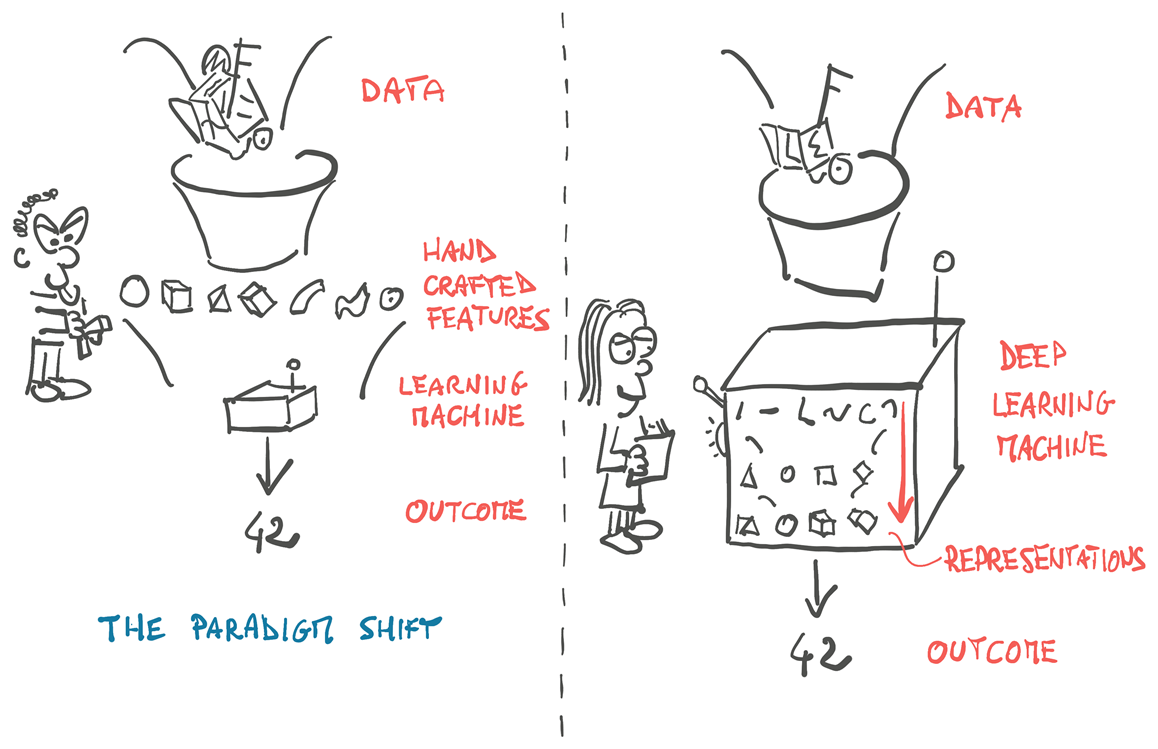

In [1]:
from IPython.display import Image
Image('figures/deeplearning.png', width=700)

#"Deep Learning with PyTorch" by Eli Stevens and Luca Antiga, Manning Publications, 2020.

At the core of **deep learning** are **neural networks** with *many* layers (hence the *deep* architecture), mathematical entities capable of representing complicated functions through a composition of simpler functions.

Deep learning focuses on designing and optimizing different neural network architecture. 

Popular architectures include:
* Convolutional Neural Networks (CNNs)

* Recurrent Neural Networks (RNNs)

* Auto-Encoders (AEs)

* Variational Auto-Encoders (VAEs)

* Generative Adversarial Networks (GANs)

* and many more...